In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import itables
from itables import show

In [ ]:
# Загружаем данные
path = 'data_eda.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0', 'IC50, mM','SI'], axis=1).rename(columns={'CC50, mM': 'CC50'})
data.head(3)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiazole,fr_thiophene,fr_unbrch_alkane,CC50
0,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,0.038844,-0.293526,0.642857,14.822266,...,0,0,0,0,0,0,0,0,3,175.482382
1,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,14.975110,...,0,0,0,0,0,0,0,0,3,5.402819
2,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,15.353938,...,0,0,0,0,2,0,0,0,3,161.142320


In [ ]:
show(data.corr()['CC50'])

Loading ITables v2.4.2 from the internet... (need help?)


In [ ]:
# Находим выбросы, ограждая по 3 сигмам
mean = data['CC50'].mean()
std = data['CC50'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

data["outlier"] = (data['CC50'] < lower_bound) | (data['CC50'] > 2000)
data['outlier_3'] = (data['CC50'] < lower_bound) | (data['CC50'] > 2000)
data_cleaned = data[~data['outlier_3']].drop(columns=['outlier', 'outlier_3'])

In [ ]:
# Делим выборку заранее, чтобы по тренировочной найти медиану, по которой и будем классифицировать
X = data_cleaned.drop('CC50', axis=1)
y = data_cleaned['CC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Получаю разбиение на классы
def define_target_value(value):
  if value > median:
    return 1

  return 0

median = y_train.median()
y_train = y_train.apply(define_target_value)
y_test = y_test.apply(define_target_value)

In [ ]:
data_cleaned['target'] = data_cleaned['CC50'].apply(define_target_value)

# Выбор признаков несколькими способами

In [ ]:
def correlation_feature_selections(df, target_col, threshold=0.1):
    # Оставляем только числовые признаки
    df_numeric = df.select_dtypes(include=[float, int])

    # Вычисляем корреляции с целевой переменной
    correlations = df_numeric.corr()[target_col].abs().sort_values(ascending=False)

    # Отбираем признаки с корреляцией выше порога
    selected_features = correlations[correlations > threshold].index.tolist()
    selected_features.remove(target_col)  # удаляем целевую переменную из признаков

    print(f"Выбранные признаки ({len(selected_features)}): {selected_features}")
    return selected_features

In [ ]:
selected_features_by_corr = correlation_feature_selections(data_cleaned.drop('CC50', axis=1), target_col='target')

Выбранные признаки (26): ['fr_NH2', 'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles', 'PEOE_VSA9', 'EState_VSA3', 'fr_Ar_OH', 'fr_allylic_oxid', 'PEOE_VSA7', 'NumAromaticHeterocycles', 'PEOE_VSA4', 'VSA_EState4', 'SMR_VSA6', 'fr_C_S', 'PEOE_VSA8', 'SMR_VSA5', 'BCUT2D_CHGLO', 'fr_sulfide', 'fr_Ndealkylation2', 'BCUT2D_MWLOW', 'fr_morpholine', 'SMR_VSA4', 'MaxPartialCharge', 'EState_VSA2', 'EState_VSA6', 'SMR_VSA3', 'MinEStateIndex']


In [ ]:
def random_forest_feature_selection(df, target_col, n_top=20):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Разделение на трейн/тест
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Получаем важность признаков
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Выводим топ-N самых важных
    top_features = importance.head(n_top).index.tolist()
    print(f"Топ-{n_top} важных признаков:\n", top_features)

    # График важности
    importance.nlargest(n_top).plot(kind='barh', figsize=(10, 8))
    plt.title("Feature Importance")
    plt.show()

    return top_features

Топ-10 важных признаков:
 ['BCUT2D_MWLOW', 'VSA_EState5', 'MinPartialCharge', 'NumSaturatedHeterocycles', 'MolLogP', 'PEOE_VSA7', 'fr_NH2', 'qed', 'BCUT2D_MRLOW', 'VSA_EState4']


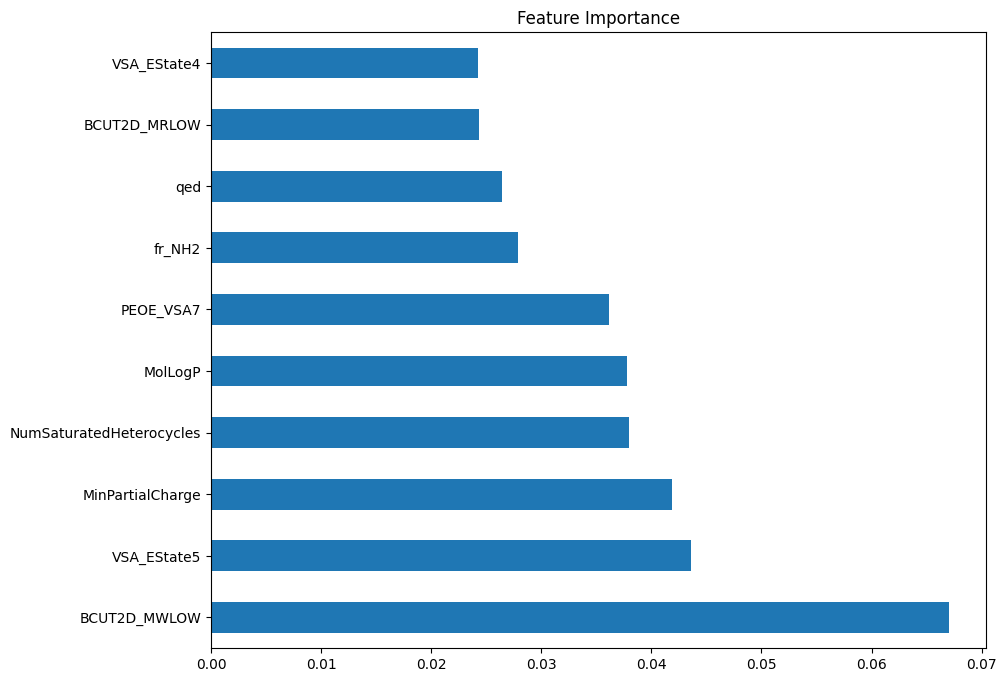

In [ ]:
selected_features_by_rand_for = random_forest_feature_selection(data_cleaned.drop('CC50', axis=1), target_col='target', n_top=10)

In [ ]:
def lasso_feature_selection(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Стандартизируем данные
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Подбор оптимального alpha и обучение Lasso
    model = LassoCV(cv=5, random_state=42, max_iter=10000)
    model.fit(X_scaled, y)

    # Определяем, какие признаки не занулены
    coef = pd.Series(model.coef_, index=X.columns)
    selected_features = coef[coef != 0].index.tolist()

    print(f"Коэффициенты:\n{coef.sort_values(ascending=False)}")
    print(f"Оставлено признаков: {len(selected_features)}")
    print("Оставленные признаки:", selected_features)

    return selected_features

In [ ]:
selected_features_by_lasso = lasso_feature_selection(data_cleaned.drop('CC50', axis=1), target_col='target')

Коэффициенты:
NumSaturatedHeterocycles    0.051759
fr_C_S                      0.025805
EState_VSA3                 0.022512
BCUT2D_CHGLO                0.018933
fr_Imine                    0.015982
                              ...   
fr_sulfide                 -0.037012
PEOE_VSA7                  -0.038140
fr_allylic_oxid            -0.048405
fr_Ar_OH                   -0.068230
fr_NH2                     -0.088613
Length: 94, dtype: float64
Оставлено признаков: 22
Оставленные признаки: ['BCUT2D_CHGLO', 'PEOE_VSA4', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SlogP_VSA3', 'EState_VSA3', 'EState_VSA4', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'fr_Ar_OH', 'fr_C_S', 'fr_Imine', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation1', 'fr_allylic_oxid', 'fr_piperzine', 'fr_priamide', 'fr_sulfide']


# Функции для перебора моделей и гиперпараметров для них с предсказанием по наилучшей

In [ ]:
def get_models():
  return {
      "Logistic Regression": {
          "model": LogisticRegression(),
          "params": {
              'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']
          }
      },
      "Random Forest": {
          "model": RandomForestClassifier(random_state=42),
          "params": {
              'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'criterion': ['gini', 'entropy']
          }
      },
      "Gradient Boosting": {
          "model": GradientBoostingClassifier(random_state=42),
          "params": {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7],
              'subsample': [0.8, 1.0],
              'min_samples_split': [2, 5]
          }
      },
      "XGBoost": {
          "model": XGBClassifier(random_state=42, eval_metric='logloss'),
          "params": {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7],
              'colsample_bytree': [0.7, 1.0],
              'subsample': [0.8, 1.0]
          }
      },
      "CatBoost": {
          "model": CatBoostClassifier(random_seed=42, verbose=0),
          "params": {
              'iterations': [100, 200],
              'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 6, 8],
              'l2_leaf_reg': [1, 3, 5, 7]
          }
      },
      "KNN": {
          "model": KNeighborsClassifier(),
          "params": {
              'n_neighbors': [3, 5, 7, 10],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]  # 1 - Manhattan, 2 - Euclidean
          }
      }
  }

In [ ]:
def start_classification(X_train_final, X_test_final):
  models = get_models()
  results = []

  for model_name, config in models.items():
      print(f"\nОбучение модели: {model_name}")

      if not config['params']:  # если нет параметров для подбора
          model = config['model']
          model.fit(X_train_final, y_train)
          best_params = {}
      else:
          grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='recall', n_jobs=-1)
          grid.fit(X_train_final, y_train)
          model = grid.best_estimator_
          best_params = grid.best_params_

      # Предсказания
      y_pred = model.predict(X_test_final)

      if hasattr(model, "predict_proba"):
          y_proba = model.predict_proba(X_test_final)[:, 1]
      else:
          y_proba = None

      # Метрики
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)

      # Если есть вероятности, считаем ROC AUC
      if y_proba is not None:
          roc_auc = roc_auc_score(y_test, y_proba)
      else:
          roc_auc = None

      results.append({
          "Model": model_name,
          "Best Params": best_params,
          "Accuracy": accuracy,
          "Precision": precision,
          "Recall": recall,
          "F1 Score": f1,
          "ROC AUC": roc_auc
      })

      print(f"Лучшие параметры: {best_params}")
      print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
      if roc_auc is not None:
          print(f"ROC AUC: {roc_auc:.4f}")
  return results

# Результаты

In [ ]:
X_train_final = X_train[selected_features_by_corr]
X_test_final = X_test[selected_features_by_corr]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res1 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7204, Precision: 0.6916, Recall: 0.7957, F1: 0.7400
ROC AUC: 0.7940

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.6828, Precision: 0.7500, Recall: 0.5484, F1: 0.6335
ROC AUC: 0.7969

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 1.0}
Accuracy: 0.6828, Precision: 0.7361, Recall: 0.5699, F1: 0.6424
ROC AUC: 0.8009

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}
Accuracy: 0.6667, Precision: 0.7246, Recall: 0.5376, F1: 0.6173
ROC AUC: 0.7644

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01

In [ ]:
X_train_final = X_train[selected_features_by_lasso]
X_test_final = X_test[selected_features_by_lasso]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res2 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7796, Precision: 0.7453, Recall: 0.8495, F1: 0.7940
ROC AUC: 0.8270

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.7419, Precision: 0.7473, Recall: 0.7312, F1: 0.7391
ROC AUC: 0.8376

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.7473, Precision: 0.7447, Recall: 0.7527, F1: 0.7487
ROC AUC: 0.8394

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.6828, Precision: 0.6809, Recall: 0.6882, F1: 0.6845
ROC AUC: 0.7504

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate'

In [ ]:
X_train_final = X_train[selected_features_by_rand_for]
X_test_final = X_test[selected_features_by_rand_for]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res3 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6882, Precision: 0.6842, Recall: 0.6989, F1: 0.6915
ROC AUC: 0.7173

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.6452, Precision: 0.7288, Recall: 0.4624, F1: 0.5658
ROC AUC: 0.7656

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.6667, Precision: 0.7460, Recall: 0.5054, F1: 0.6026
ROC AUC: 0.7698

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.5968, Precision: 0.6250, Recall: 0.4839, F1: 0.5455
ROC AUC: 0.7033

Обучение модели: CatBoost
Лучшие параметры: {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.

С учетом спефицифики показателя, который мы пытаемся предсказать - нам важно определять верно токсичные препараты. Если исходить из того, что пропустить токсичный вариант для нас хуже, чем забраковать нетоксичный вариант, то лучше опираться на метрику Recall. Если же для нас критично забраковать потенциально хорошего (нетоксичного) препарата не менее, чем пропустить токсичный вариант, то стоит опираться на F1-Score, который основывается на Precision и Recall.

1) Нам важнее не пропустить токсичный вариант, чем все остальное: тут лучше всего подойдут данные, включающие в себя признаки, отобранные случайным лесом, модель Случайный Лес, лучшие параметры: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}. Метрики: Accuracy: 0.8441, Precision: 0.9571, Recall: 0.7204, F1: 0.8221, ROC AUC: 0.9214

2) Если нам важно и не забраковать хороший вариант и не пропустить токсичное в равной степени: выбираем вариант, где данные включали в себя признаки, отобранные с помощью Случайного Леса, Модель CatBoost, лучшие параметры: {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}. Метрики: Accuracy: 0.8441, Precision: 0.9000, Recall: 0.7742, F1: 0.8324, ROC AUC: 0.9061.

3) Если оценивать в целом, какая модель определяет лучше всего, то будем опираться на метрику ROC-AUC. Лидером становится модель, признаки для данных у которой отбирали с помощью Лассо, модель CatBoost с лучшими параметрами {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.05}. Метрики: Accuracy: 0.8226, Precision: 0.9054, Recall: 0.7204, F1: 0.8024
ROC AUC: 0.9238